# Noise simulation

`tal noise_simulation` simulates the noise introduced in transient captures by SPAD sensors. The time jitter present in the SPAD,
 as well as the temporal width of the laser pulses introduce temporal uncertainty in the captured photons. Furthermore, `tal` allows
 the simulation of other sources of noise, such as dark counts and triggers caused by ambient light, as well as artifacts caused
 by the afterpulsing of the detected photons.

In [187]:
import numpy as np
import tal
from tal.io import read_capture
import matplotlib.pyplot as plt
import os
import yaml
import subprocess

# TODO: if you want to follow this tutorial,
# you need to have rendered the scene using the "tal render nlos-z" shell command
# See README.md for more information
# Write here   vvvvvvvvvvvvvvv   the path to your rendered scene
root = 'nlos-z/YYYYMMDD-HHMMSS'

capture_path = f'{root}/nlos-z.hdf5'                        # Input transient capture path
output_path = f'{root}/nlos-z-noisy.hdf5'                   # Output path
noise_configuration_path = 'configuration.yaml'             # Path to the .yaml for the configuration of the noise
noise_configuration_copy_path = 'configuration-copy.yaml'
noise_configuration_dict = yaml.safe_load(open(noise_configuration_path, 'r'))


def save_yaml(path, data):
    with open(path, 'w') as file:
        yaml.dump(data, file)

## Setting a time jitter function

The time jitter function of the system to simulate can be either loaded from an hdf5 file, or generated given its parameters.
The time jitter file must have the following fields:
- counts: transient signal of the time jitter
- n_timebins: number of timebins
- timebin_width_ps: temporal width of the timebins, in picoseconds

In [188]:
# Loading a time jitter function from file
noise_configuration_dict['time_jitter_path'] = './spad_data_1.hdf5'
save_yaml(noise_configuration_copy_path, noise_configuration_dict) # Save a modified copy of the configuration

# Execute the noise simulation
subprocess.run(["tal", "noise_simulation", "-c", f'{capture_path}', "-o", f'{output_path}', "-n", f'{noise_configuration_copy_path}'])

# Load the transient data (original and processed)
H_original = read_capture(capture_path)
H_noisy = read_capture(output_path)

Simulating noise for capture data nlos-z/20250908-120715/nlos-z.hdf5.
 - Jitter function loaded from ./spad_data_1.hdf5.
 - Photon detection ratio = 30.00 %.
 - Simulated exposure time = 0.001 seconds.
 - Laser frequency = 20.00 MHz.
 - Number of photons sampled = 6000
 - Number of false positive samples = 0


Simulating noise (6000 samples per measurement)...: 100%|██████████| 1024/1024 [00:00<00:00, 1567.55it/s]


DONE. Noise simulation took 0.658 seconds
Processed capture saved to nlos-z/20250908-120715/nlos-z-noisy.hdf5


The noise simulation works by randomly sampling photons from the original signal. These photons will then have a random jitter value applied, sampled from the defined time jitter function.

Text(0.5, 0, 'Time (0.75ps)')

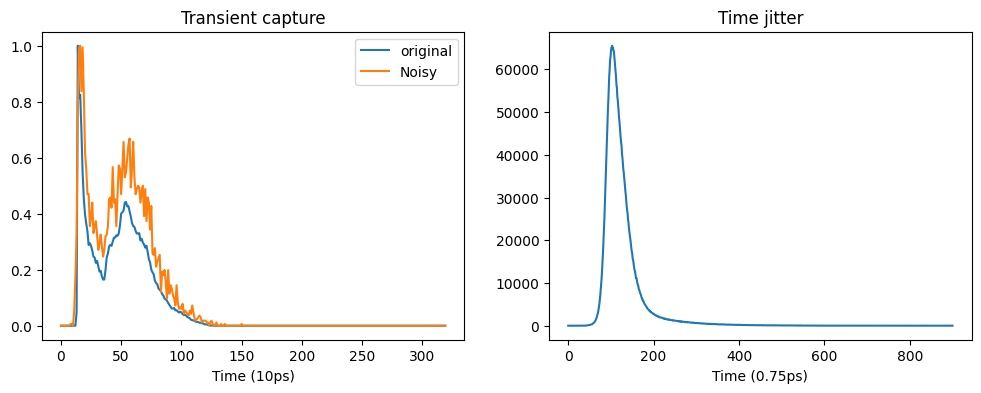

In [189]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Note that the difference in y-axis scale is caused by the normalization and differences between peaks caused by noise
axes[0].plot(H_original.H[:, 16, 16] / np.max(H_original.H[:, 16, 16]), label='original')
axes[0].plot(H_noisy.H[:, 16, 16] / np.max(H_noisy.H[:, 16, 16]), label='Noisy')
axes[1].plot(H_noisy.jitter['counts'])

axes[0].set_title('Transient capture'); axes[0].legend(); axes[1].set_title('Time jitter')
axes[0].set_xlabel('Time (10ps)'); axes[1].set_xlabel('Time (0.75ps)')

In [190]:
# Loading a different time jitter function
noise_configuration_dict['time_jitter_path'] = './spad_data_2.hdf5'
save_yaml(noise_configuration_copy_path, noise_configuration_dict)

subprocess.run(["tal", "noise_simulation", "-c", f'{capture_path}', "-o", f'{output_path}', "-n", f'{noise_configuration_copy_path}'])
H_noisy = read_capture(output_path)

Simulating noise for capture data nlos-z/20250908-120715/nlos-z.hdf5.
 - Jitter function loaded from ./spad_data_2.hdf5.
 - Photon detection ratio = 30.00 %.
 - Simulated exposure time = 0.001 seconds.
 - Laser frequency = 20.00 MHz.
 - Number of photons sampled = 6000
 - Number of false positive samples = 0


Simulating noise (6000 samples per measurement)...: 100%|██████████| 1024/1024 [00:00<00:00, 1593.39it/s]


DONE. Noise simulation took 0.647 seconds
Processed capture saved to nlos-z/20250908-120715/nlos-z-noisy.hdf5


Text(0.5, 0, 'Time (0.75ps)')

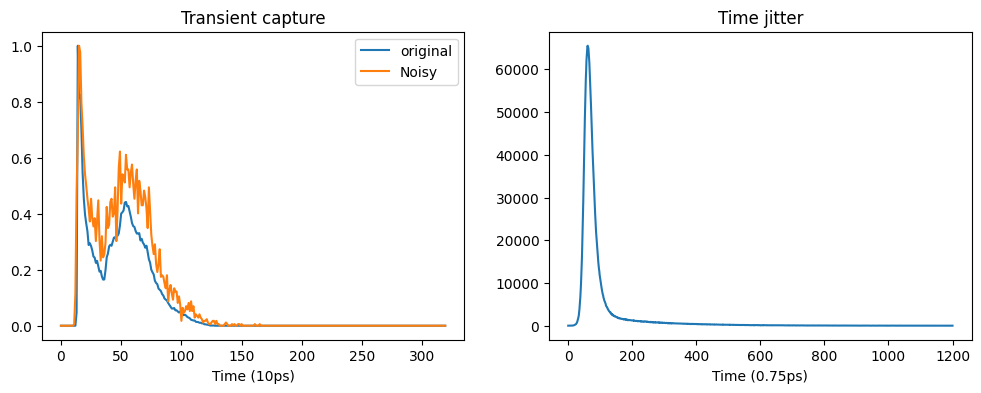

In [191]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(H_original.H[:, 16, 16] / np.max(H_original.H[:, 16, 16]), label='original')
axes[0].plot(H_noisy.H[:, 16, 16] / np.max(H_noisy.H[:, 16, 16]), label='Noisy')
axes[1].plot(H_noisy.jitter['counts'])

axes[0].set_title('Transient capture'); axes[0].legend(); axes[1].set_title('Time jitter')
axes[0].set_xlabel('Time (10ps)'); axes[1].set_xlabel('Time (0.75ps)')

A parametric time jitter function is defined the temporal jitter of the SPAD (as an exponentially modified gaussian)
and the gaussian pulse of the laser. It can be configured modifying the following parameters:
- time_jitter_FWHM: full width at half maximum (FWHM) of the SPAD jitter
- time_jitter_tail: exponential decay parameter of the SPAD jitter's tail
- laser_jitter_FWHM: FWHM of the gaussian laser pulse

In [192]:
noise_configuration_dict['time_jitter_FWHM'] = 30
noise_configuration_dict['time_jitter_tail'] = 70
noise_configuration_dict['laser_jitter_FWHM'] = 45
noise_configuration_dict['time_jitter_path'] = ''
save_yaml(noise_configuration_copy_path, noise_configuration_dict)

subprocess.run(["tal", "noise_simulation", "-c", f'{capture_path}', "-o", f'{output_path}', "-n", f'{noise_configuration_copy_path}'])
H_noisy = read_capture(output_path)

Simulating noise for capture data nlos-z/20250908-120715/nlos-z.hdf5.
 - Jitter function:
   - SPAD FWHM = 30 ps
   - SPAD tail = 70 ps
   - Laser FWHM = 45 ps
 - Photon detection ratio = 30.00 %.
 - Simulated exposure time = 0.001 seconds.
 - Laser frequency = 20.00 MHz.
 - Number of photons sampled = 6000
 - Number of false positive samples = 0


Simulating noise (6000 samples per measurement)...: 100%|██████████| 1024/1024 [00:00<00:00, 1497.80it/s]


DONE. Noise simulation took 0.688 seconds
Processed capture saved to nlos-z/20250908-120715/nlos-z-noisy.hdf5


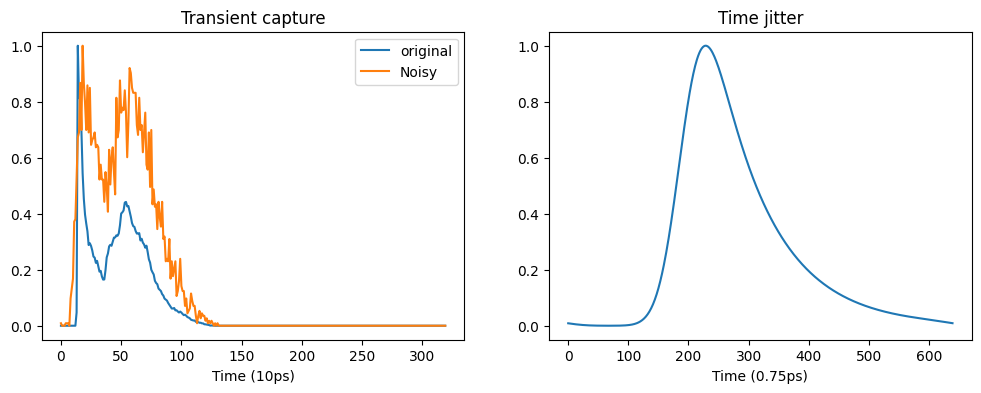

In [193]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(H_original.H[:, 16, 16] / np.max(H_original.H[:, 16, 16]), label='original')
axes[0].plot(H_noisy.H[:, 16, 16] / np.max(H_noisy.H[:, 16, 16]), label='Noisy')
axes[1].plot(H_noisy.jitter['counts'])

axes[0].set_title('Transient capture'); axes[0].legend(); axes[1].set_title('Time jitter')
axes[0].set_xlabel('Time (10ps)'); axes[1].set_xlabel('Time (0.75ps)');

## Changing the number of samples

The number of sampled photons is controlled by setting:
- exposure_time: capture time for each of the measured points
- frequency: laser pulse frequency (number of emissions per seconds)
- photon_detection_ratio: percentage of the photons that reach the sensor that will trigger an avalanche

In [194]:
noise_configuration_dict['exposure_time'] = 0.001 # Exposure time of 1 millisecond (per measured point)
noise_configuration_dict['frequency'] = 20        # Laser frequency in MHz
noise_configuration_dict['photon_detection_ratio'] = 0.3
save_yaml(noise_configuration_copy_path, noise_configuration_dict)

subprocess.run(["tal", "noise_simulation", "-c", f'{capture_path}', "-o", f'{output_path}', "-n", f'{noise_configuration_copy_path}'])
H_noisy = read_capture(output_path)

Simulating noise for capture data nlos-z/20250908-120715/nlos-z.hdf5.
 - Jitter function:
   - SPAD FWHM = 30 ps
   - SPAD tail = 70 ps
   - Laser FWHM = 45 ps
 - Photon detection ratio = 30.00 %.
 - Simulated exposure time = 0.001 seconds.
 - Laser frequency = 20.00 MHz.
 - Number of photons sampled = 6000
 - Number of false positive samples = 0


Simulating noise (6000 samples per measurement)...: 100%|██████████| 1024/1024 [00:00<00:00, 1556.68it/s]


DONE. Noise simulation took 0.662 seconds
Processed capture saved to nlos-z/20250908-120715/nlos-z-noisy.hdf5


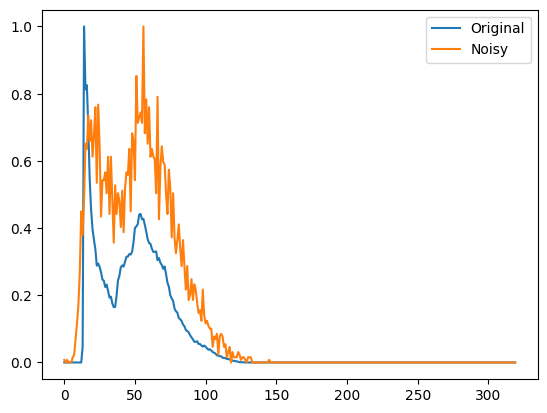

In [195]:
plt.plot(H_original.H[:, 16, 16] / np.max(H_original.H[:, 16, 16]), label='Original')
plt.plot(H_noisy.H[:, 16, 16] / np.max(H_noisy.H[:, 16, 16]), label='Noisy')
plt.legend()

In [196]:
noise_configuration_dict['exposure_time'] = 0.010  # Increasing exposure time also increases the number of photons, reducing noise
noise_configuration_dict['frequency'] = 20
noise_configuration_dict['photon_detection_ratio'] = 0.3
save_yaml(noise_configuration_copy_path, noise_configuration_dict)

subprocess.run(["tal", "noise_simulation", "-c", f'{capture_path}', "-o", f'{output_path}', "-n", f'{noise_configuration_copy_path}'])
H_noisy = read_capture(output_path)

Simulating noise for capture data nlos-z/20250908-120715/nlos-z.hdf5.
 - Jitter function:
   - SPAD FWHM = 30 ps
   - SPAD tail = 70 ps
   - Laser FWHM = 45 ps
 - Photon detection ratio = 30.00 %.
 - Simulated exposure time = 0.010 seconds.
 - Laser frequency = 20.00 MHz.
 - Number of photons sampled = 60000
 - Number of false positive samples = 0


Simulating noise (60000 samples per measurement)...: 100%|██████████| 1024/1024 [00:03<00:00, 289.52it/s]


DONE. Noise simulation took 3.541 seconds
Processed capture saved to nlos-z/20250908-120715/nlos-z-noisy.hdf5


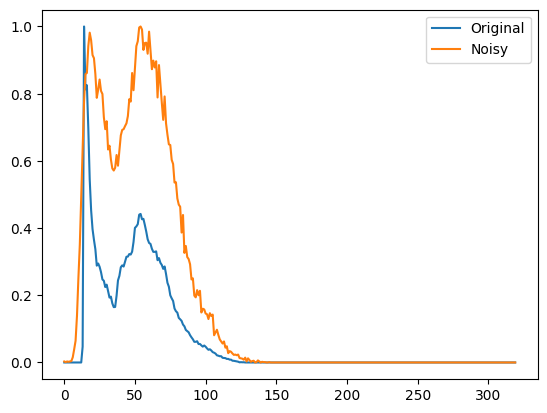

In [197]:
plt.plot(H_original.H[:, 16, 16] / np.max(H_original.H[:, 16, 16]), label='Original')
plt.plot(H_noisy.H[:, 16, 16] / np.max(H_noisy.H[:, 16, 16]), label='Noisy')
plt.legend()

If desired, the number of sampled photons can also be set manually by modifying the `number_of_samples` field.

In [198]:
noise_configuration_dict['number_of_samples'] = 100000 # Manually setting the number of samples overrides the exposure time & laser frequency
save_yaml(noise_configuration_copy_path, noise_configuration_dict)

subprocess.run(["tal", "noise_simulation", "-c", f'{capture_path}', "-o", f'{output_path}', "-n", f'{noise_configuration_copy_path}'])
H_noisy = read_capture(output_path)

Simulating noise for capture data nlos-z/20250908-120715/nlos-z.hdf5.
 - Jitter function:
   - SPAD FWHM = 30 ps
   - SPAD tail = 70 ps
   - Laser FWHM = 45 ps
 - Photon detection ratio = 30.00 %.
 - Number of photons sampled = 100000
 - Number of false positive samples = 0


Simulating noise (100000 samples per measurement)...: 100%|██████████| 1024/1024 [00:05<00:00, 196.28it/s]


DONE. Noise simulation took 5.221 seconds
Processed capture saved to nlos-z/20250908-120715/nlos-z-noisy.hdf5


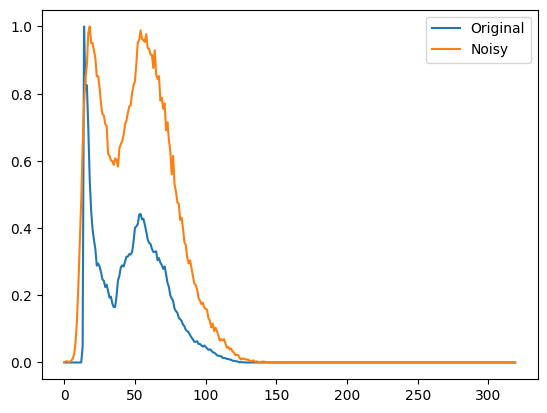

In [199]:
plt.plot(H_original.H[:, 16, 16] / np.max(H_original.H[:, 16, 16]), label='Original')
plt.plot(H_noisy.H[:, 16, 16] / np.max(H_noisy.H[:, 16, 16]), label='Noisy')
plt.legend()

## Other noise sources
Besides the time jitter, SPADs also experiment noise from avalanches caused by internal charges, known as dark counts.
Furthermore, ambient light will cause false positive photon detections. These noise sources can be configured by
modifying the following fields:
- 'dark_count_rate': number of detected dark counts per second
- 'external_noise_rate': number of counts caused by ambient light per second

The number of these 'false positive' samples, will be computed from the set rates and the exposure time, and sampled
from an uniform distribution.

In [200]:
noise_configuration_dict['dark_count_rate'] = 1000
noise_configuration_dict['external_noise_rate'] = 100000
noise_configuration_dict['number_of_samples'] = 30000
save_yaml(noise_configuration_copy_path, noise_configuration_dict)

subprocess.run(["tal", "noise_simulation", "-c", f'{capture_path}', "-o", f'{output_path}', "-n", f'{noise_configuration_copy_path}'])
H_noisy = read_capture(output_path)

Simulating noise for capture data nlos-z/20250908-120715/nlos-z.hdf5.
 - Jitter function:
   - SPAD FWHM = 30 ps
   - SPAD tail = 70 ps
   - Laser FWHM = 45 ps
 - Photon detection ratio = 30.00 %.
 - Number of photons sampled = 30000
 - Number of false positive samples = 1010


Simulating noise (30000 samples per measurement)...: 100%|██████████| 1024/1024 [00:01<00:00, 536.62it/s]


DONE. Noise simulation took 1.912 seconds
Processed capture saved to nlos-z/20250908-120715/nlos-z-noisy.hdf5


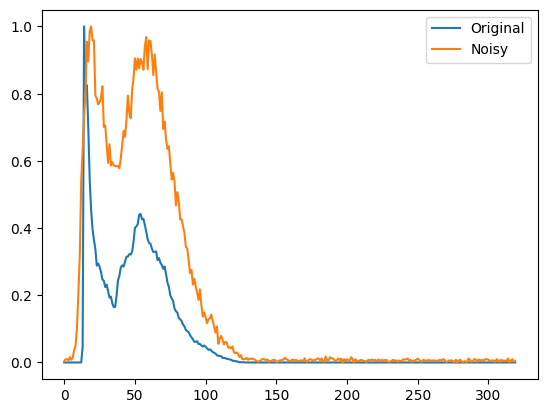

In [201]:
plt.plot(H_original.H[:, 16, 16] / np.max(H_original.H[:, 16, 16]), label='Original')
plt.plot(H_noisy.H[:, 16, 16] / np.max(H_noisy.H[:, 16, 16]), label='Noisy')
plt.legend()

If desired, the number of sampled photons can also be set manually by modifying the `number_of_samples` field.

In [202]:
noise_configuration_dict['number_of_false_counts'] = 3000 # Overrides the noise computed with the dark count and ambient rates
save_yaml(noise_configuration_copy_path, noise_configuration_dict)

subprocess.run(["tal", "noise_simulation", "-c", f'{capture_path}', "-o", f'{output_path}', "-n", f'{noise_configuration_copy_path}'])
H_noisy = read_capture(output_path)

Simulating noise for capture data nlos-z/20250908-120715/nlos-z.hdf5.
 - Jitter function:
   - SPAD FWHM = 30 ps
   - SPAD tail = 70 ps
   - Laser FWHM = 45 ps
 - Photon detection ratio = 30.00 %.
 - Number of photons sampled = 30000
 - Number of false positive samples = 3000


Simulating noise (30000 samples per measurement)...: 100%|██████████| 1024/1024 [00:01<00:00, 548.05it/s]


DONE. Noise simulation took 1.873 seconds
Processed capture saved to nlos-z/20250908-120715/nlos-z-noisy.hdf5


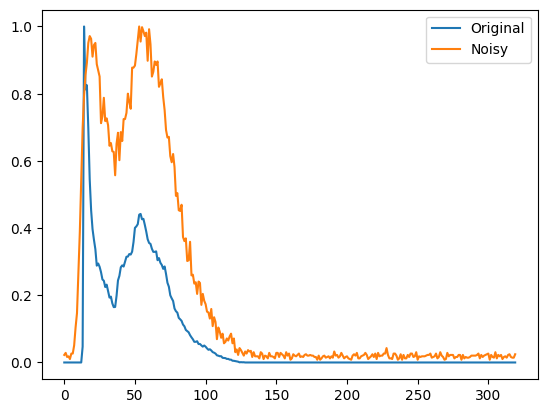

In [203]:
plt.plot(H_original.H[:, 16, 16] / np.max(H_original.H[:, 16, 16]), label='Original')
plt.plot(H_noisy.H[:, 16, 16] / np.max(H_noisy.H[:, 16, 16]), label='Noisy')
plt.legend()

## Afterpulsing

After the SPAD detects a photon, the sensor won't be able to detect any new photons after a certain period of time,
known as dead time (or hold-off). In some cases, the carrier that caused the avalanche get trapped in the circuit,
which causes them to be detected again, creating an additional delayed avalanche. To configure this behavior,
the following fields can be modified:
- simulate_afterpulses: set to `True`, to enable afterpulses
- dead_time: dead time of the SPAD after detecting a photon, in picoseconds
- afterpulse_probability: probability of a photon causing an afterpulse

In [204]:
noise_configuration_dict['simulate_afterpulses'] = True
noise_configuration_dict['dead_time'] = 1000
noise_configuration_dict['afterpulse_probability'] = 0.15
save_yaml(noise_configuration_copy_path, noise_configuration_dict)

subprocess.run(["tal", "noise_simulation", "-c", f'{capture_path}', "-o", f'{output_path}', "-n", f'{noise_configuration_copy_path}'])
H_noisy = read_capture(output_path)

Simulating noise for capture data nlos-z/20250908-120715/nlos-z.hdf5.
 - Jitter function:
   - SPAD FWHM = 30 ps
   - SPAD tail = 70 ps
   - Laser FWHM = 45 ps
 - Photon detection ratio = 30.00 %.
 - SPAD dead time = 1000 ps
 - Afterpulse probability = 15.00 %
 - Number of photons sampled = 30000
 - Number of false positive samples = 3000


Simulating noise (30000 samples per measurement)...: 100%|██████████| 1024/1024 [00:02<00:00, 368.05it/s]


DONE. Noise simulation took 2.787 seconds
Processed capture saved to nlos-z/20250908-120715/nlos-z-noisy.hdf5


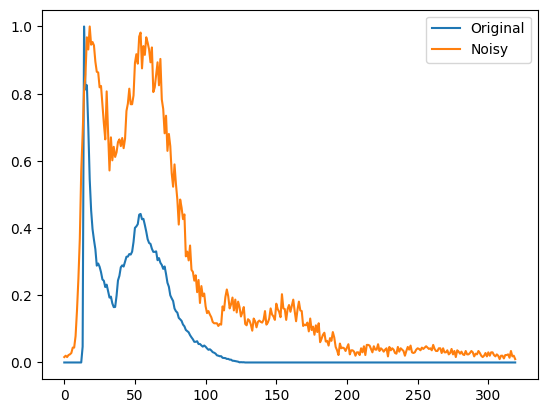

In [205]:
plt.plot(H_original.H[:, 16, 16] / np.max(H_original.H[:, 16, 16]), label='Original')
plt.plot(H_noisy.H[:, 16, 16] / np.max(H_noisy.H[:, 16, 16]), label='Noisy')
plt.legend()

Increasing the dead time causes the peaks produced by afterpulsing to appear further away from the original pulses.
Furthermore, a higher probability of afterpulsing causes this subsequent pulses to appear with higher intensities.

In [206]:
noise_configuration_dict['dead_time'] = 1500
noise_configuration_dict['afterpulse_probability'] = 0.40
save_yaml(noise_configuration_copy_path, noise_configuration_dict)

subprocess.run(["tal", "noise_simulation", "-c", f'{capture_path}', "-o", f'{output_path}', "-n", f'{noise_configuration_copy_path}'])
H_noisy = read_capture(output_path)

Simulating noise for capture data nlos-z/20250908-120715/nlos-z.hdf5.
 - Jitter function:
   - SPAD FWHM = 30 ps
   - SPAD tail = 70 ps
   - Laser FWHM = 45 ps
 - Photon detection ratio = 30.00 %.
 - SPAD dead time = 1500 ps
 - Afterpulse probability = 40.00 %
 - Number of photons sampled = 30000
 - Number of false positive samples = 3000


Simulating noise (30000 samples per measurement)...: 100%|██████████| 1024/1024 [00:02<00:00, 360.64it/s]


DONE. Noise simulation took 2.844 seconds
Processed capture saved to nlos-z/20250908-120715/nlos-z-noisy.hdf5


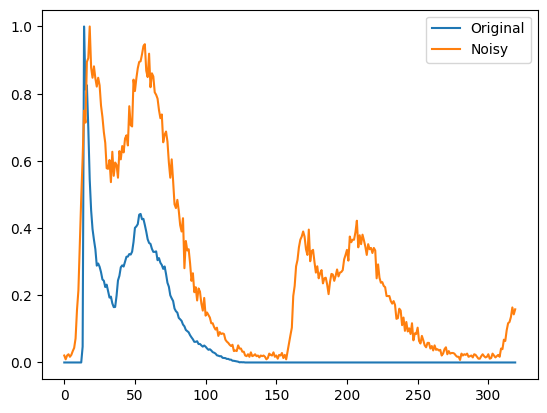

In [207]:
plt.plot(H_original.H[:, 16, 16] / np.max(H_original.H[:, 16, 16]), label='Original')
plt.plot(H_noisy.H[:, 16, 16] / np.max(H_noisy.H[:, 16, 16]), label='Noisy')
plt.legend()